In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
import random
from datetime import datetime

In [2]:
df_1 = pd.read_csv('train.csv')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [3]:
#number of rows i want in the train and test dataframes
rowNum = 10000

testIdx = []
trainIdx = []

#randomly pick the indexes from each dataframe that will go into the train and test dataframes
while len(trainIdx) < rowNum:
    num = random.randint(0, len(df_1)-1)
    if not num in trainIdx:
        trainIdx.append(num)

while len(testIdx) < rowNum:
    num = random.randint(0, len(df_1)-1)
    if not num in testIdx:
        testIdx.append(num)

In [4]:
trainDF = df_1.iloc[trainIdx].reset_index(drop=True)
testDF = df_1.iloc[testIdx].reset_index(drop=True)

In [5]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radius of the Earth in kilometers (you can change it to miles if needed)
    radius_earth_km = 6371.0

    # Calculate the distance
    distance = radius_earth_km * c

    return distance

In [6]:
# # Example coordinates (latitude and longitude) for two points
# latitude1, longitude1 = 40.767937, -73.982155
# latitude2, longitude2 = 40.765602, -73.964630

# # Calculate the distance
# distance_km = haversine_distance(latitude1, longitude1, latitude2, longitude2)

# print(f"The distance between the two points is {distance_km:.2f} kilometers.")

In [7]:
distCol = []
timeInMinCol = []

for i in range(len(trainDF)):
    latitude1, longitude1 = trainDF.at[i, 'pickup_latitude'], trainDF.at[i, 'pickup_longitude']
    latitude2, longitude2 = trainDF.at[i, 'dropoff_latitude'], trainDF.at[i, 'dropoff_longitude']
    
    distance = round(haversine_distance(latitude1, longitude1, latitude2, longitude2), 2)
    time = round(trainDF.at[i, 'trip_duration']/60, 3)
    
    distCol.append(distance)
    timeInMinCol.append(time)

trainDF['totalDist_km'] = distCol
trainDF['timeInMin'] = timeInMinCol

distCol.clear()
timeInMinCol.clear()

for i in range(len(testDF)):
    latitude1, longitude1 = testDF.at[i, 'pickup_latitude'], testDF.at[i, 'pickup_longitude']
    latitude2, longitude2 = testDF.at[i, 'dropoff_latitude'], testDF.at[i, 'dropoff_longitude']
    
    distance = round(haversine_distance(latitude1, longitude1, latitude2, longitude2), 2)
    time = round(testDF.at[i, 'trip_duration']/60, 3)
    
    distCol.append(distance)
    timeInMinCol.append(time)

testDF['totalDist_km'] = distCol
testDF['timeInMin'] = timeInMinCol

In [8]:
trainDF['season'] = 'unknown'
testDF['season'] = 'unknown'

#seasons and their [start,end] days of the year

spring = [79,172]
summer = [173,266]
fall = [267, 354]
winter = [356,78]

def calcSeason(day):
    if day > spring[0] and day < spring[1]:
        return 'spring'
    elif day > summer[0] and day < summer[1]:
        return 'summer'
    elif day > fall[0] and day < fall[1]:
        return 'fall'
    else:
        return 'winter'

for i in range(len(trainDF)):
    date_format = '%Y-%m-%d %H:%M:%S'
    date = datetime.strptime(trainDF.loc[i,'pickup_datetime'], date_format)
    day = date.timetuple().tm_yday
    season = calcSeason(day)
    trainDF.loc[i, 'season'] = season
    
for i in range(len(testDF)):
    date_format = '%Y-%m-%d %H:%M:%S'
    date = datetime.strptime(testDF.loc[i,'pickup_datetime'], date_format)
    day = date.timetuple().tm_yday
    season = calcSeason(day)
    testDF.loc[i, 'season'] = season
    
testDF.head(50)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,totalDist_km,timeInMin,season
0,id2714601,1,2016-02-26 19:38:05,2016-02-26 19:50:26,1,-73.980949,40.764790,-73.955177,40.780781,N,741,2.81,12.350,winter
1,id3167593,1,2016-03-09 20:38:16,2016-03-09 20:42:25,1,-73.978142,40.757244,-73.984192,40.748852,N,249,1.06,4.150,winter
2,id3748562,1,2016-05-27 01:03:26,2016-05-27 01:16:25,1,-73.993156,40.756981,-73.961578,40.760323,N,779,2.69,12.983,spring
3,id2436302,1,2016-05-25 15:33:25,2016-05-25 16:02:01,1,-74.008034,40.708065,-74.004044,40.744370,N,1716,4.05,28.600,spring
4,id0447291,2,2016-03-17 09:00:23,2016-03-17 09:13:49,1,-73.985077,40.764004,-74.005157,40.751480,N,806,2.19,13.433,winter
5,id2900410,1,2016-04-01 01:37:37,2016-04-01 01:51:38,2,-73.789963,40.647243,-73.729401,40.612041,N,841,6.44,14.017,spring
6,id0429344,2,2016-01-19 14:12:28,2016-01-19 14:30:24,2,-73.999794,40.734070,-73.995056,40.693275,N,1076,4.55,17.933,winter
7,id3720194,1,2016-06-01 21:38:46,2016-06-01 21:43:45,1,-73.966698,40.757462,-73.952423,40.772743,N,299,2.08,4.983,spring
8,id2051976,2,2016-02-29 20:28:40,2016-02-29 20:35:30,2,-73.945374,40.778397,-73.952003,40.790596,N,410,1.47,6.833,winter
9,id1709134,1,2016-06-28 10:26:50,2016-06-28 10:43:59,1,-73.976509,40.745003,-73.985168,40.751175,N,1029,1.00,17.150,summer


In [9]:
#drops datapoins that are percieved outliers

idxToDrop = []
for i in range(len(trainDF)):
    if trainDF.loc[i, 'timeInMin'] > 200:
        idxToDrop.append(i)
    elif trainDF.loc[i, 'totalDist_km'] > 50:
        idxToDrop.append(i)
trainDF_dropped = trainDF.drop(idxToDrop)
trainDF_dropped = trainDF_dropped.reset_index(drop=True)

idxToDrop.clear()
for i in range(len(testDF)):
    if testDF.loc[i, 'timeInMin'] > 200:
        idxToDrop.append(i)
    elif testDF.loc[i, 'totalDist_km'] > 50:
        idxToDrop.append(i)
testDF_dropped = testDF.drop(idxToDrop)
testDF_dropped = testDF_dropped.reset_index(drop=True)

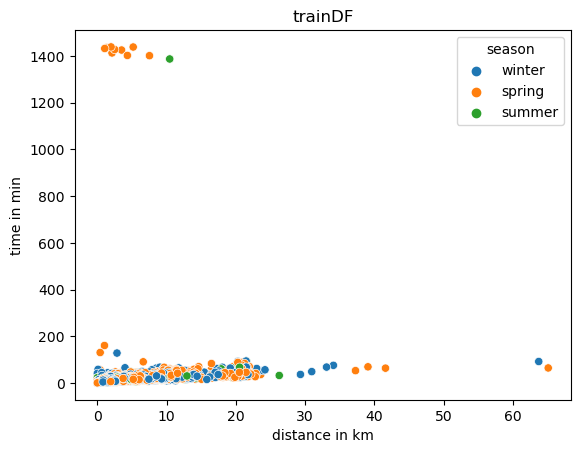

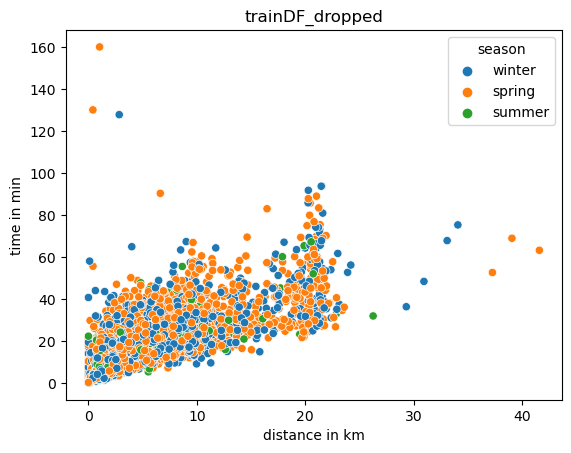

In [10]:
sns.scatterplot(x=trainDF['totalDist_km'], y=trainDF['timeInMin'], hue=trainDF['season'])

# Set labels and title
plt.xlabel('distance in km')
plt.ylabel('time in min')
plt.title('trainDF')

# Show the plot
plt.show()

sns.scatterplot(x=trainDF_dropped['totalDist_km'], y=trainDF_dropped['timeInMin'], hue=trainDF_dropped['season'])

# Set labels and title
plt.xlabel('distance in km')
plt.ylabel('time in min')
plt.title('trainDF_dropped')

# Show the plot
plt.show()

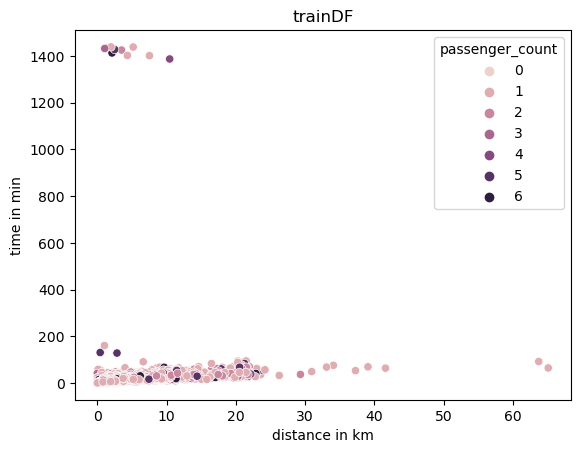

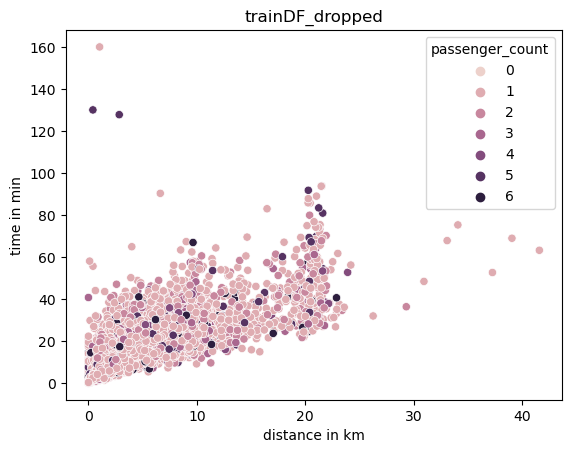

In [11]:
sns.scatterplot(x=trainDF['totalDist_km'], y=trainDF['timeInMin'], hue=trainDF['passenger_count'])

# Set labels and title
plt.xlabel('distance in km')
plt.ylabel('time in min')
plt.title('trainDF')

# Show the plot
plt.show()

sns.scatterplot(x=trainDF_dropped['totalDist_km'], y=trainDF_dropped['timeInMin'], hue=trainDF_dropped['passenger_count'])

# Set labels and title
plt.xlabel('distance in km')
plt.ylabel('time in min')
plt.title('trainDF_dropped')

# Show the plot
plt.show()

In [15]:
#equation: y = Mx + B
#B must be between 10 and 30
#M must be between 0.5 and 1.5

def trainModel():
    M = round(random.uniform(0.5, 1.5),2)
    B = round(random.uniform(10, 30),2)
    return M, B

def testModel(df, M, B):
    testNums = []
    for i in range(len(df)):
        actual = df.loc[i, 'timeInMin']
        estimate = M * df.loc[i, 'totalDist_km'] + B
        testNums.append((actual - estimate)**2)
       
    return (sum(testNums) / len(testNums))**0.5

rmseMins_lin = {'rmse':[], 'M':[], 'B':[]}
rmseMins_lin = pd.DataFrame(rmseMins_lin)
for i in range(10):
    rmseNums = {'rmse':[], 'M':[], 'B':[]}
    rmseNums = pd.DataFrame(rmseNums)
    for j in range(100):
        M, B = trainModel()
        rmse = testModel(testDF_dropped, M, B)
        locDF = {'rmse': [rmse], 'M': [M], 'B':[B]}
        locDF = pd.DataFrame(locDF)
        rmseNums = pd.concat([rmseNums, locDF], ignore_index=True)

    minRMSE = min(rmseNums['rmse'])
    minIdx = rmseNums.index[rmseNums['rmse'] == minRMSE]
    rmseMins_lin = pd.concat([rmseMins_lin, rmseNums.loc[minIdx]], ignore_index=True)

In [18]:
rmseMins_lin.head()

,rmse,M,B
0,7.882254,1.37,10.13
1,7.766610,1.48,10.08
2,7.826976,1.49,10.47
3,7.801879,1.48,10.30
4,7.929858,1.40,10.67


In [20]:
minimum = min(rmseMins_lin['rmse'])
minIdx = rmseMins_lin.index[rmseMins_lin['rmse'] == minimum]
rmseMins_lin.loc[minIdx]

,rmse,M,B
1,7.76661,1.48,10.08
